Simulated 10000 terminal payoffs ST (vector in R^10000)
Sample min: 48.46, max: 232.86, mean: 108.30
Interpretation: Each ST[i] is a payoff in one 'state'—discrete approximation of continuous uncertainty for realistic distributions.


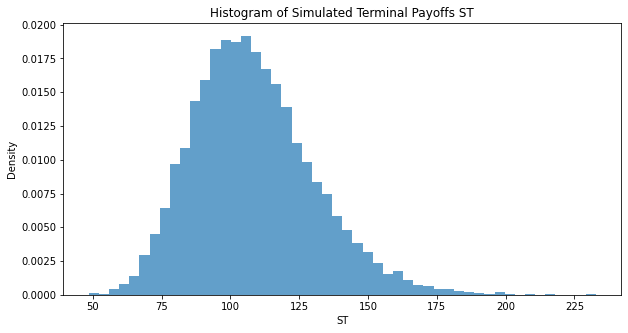

Moments (uniform P):
  Mean E[ST]: 108.30
  Variance: 482.46
  Std Dev: 21.97

Weighted mean with skewed P: 106.68 (vs uniform 108.30)
Explanation: P enters as weights—uniform for risk-neutral/MC; real/historical P for physical expectations (e.g., biased views shift mean).

Payoff matrix M: 10000 states x 5 assets
  Rank of M: 5
  Market: Incomplete (rank 5 < 10000 states)
Interpretation: Low rank (always here since assets << states) → incomplete market. Can't replicate arbitrary claims—real-world limit even in 'large' economies (e.g., thousands of paths, few assets).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Task 1: Simulate payoff sample ST as vector in R^|Ω| (large discrete space)
# Real-world tie-in: Large |Ω| approximates continuous distributions (e.g., Monte Carlo for TSLA terminal prices under lognormal—realistic for option pricing with many paths).
np.random.seed(42)  # Fixed for reproducibility
num_paths = 10000   # Large state space |Ω| = 10,000 scenarios
S0 = 100            # Initial stock price
mu = 0.08           # Drift
sigma = 0.2         # Volatility
T = 1.0             # Time horizon

# Simulate terminal payoffs ST (lognormal geometric Brownian motion approximation)
Z = np.random.standard_normal(num_paths)
ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

print(f"Simulated {num_paths} terminal payoffs ST (vector in R^{num_paths})")
print(f"Sample min: {ST.min():.2f}, max: {ST.max():.2f}, mean: {ST.mean():.2f}")
print("Interpretation: Each ST[i] is a payoff in one 'state'—discrete approximation of continuous uncertainty for realistic distributions.")

# Task 2: Histogram and basic moments; role of probability vector P
# Real-world: Histogram visualizes distribution (e.g., TSLA return vol); moments for risk (mean return, variance). Uniform P assumes equal likelihood; real P from historical/data for weighted expectations.
plt.figure(figsize=(10, 5))
plt.hist(ST, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Simulated Terminal Payoffs ST')
plt.xlabel('ST')
plt.ylabel('Density')
plt.show()

# Basic moments (assuming uniform P: equal weight 1/num_paths)
mean_ST = np.mean(ST)
var_ST = np.var(ST)
std_ST = np.std(ST)

print(f"Moments (uniform P):")
print(f"  Mean E[ST]: {mean_ST:.2f}")
print(f"  Variance: {var_ST:.2f}")
print(f"  Std Dev: {std_ST:.2f}")

# Role of P: Weighted expectation E[ST] = sum P_i * ST_i
# Example: Skewed P favoring low states (e.g., bearish view)
P_skewed = np.exp(-0.001 * (ST - ST.mean())**2)  # Dummy weights higher near mean for illustration
P_skewed /= P_skewed.sum()  # Normalize to probabilities

weighted_mean = np.dot(P_skewed, ST)
print(f"\nWeighted mean with skewed P: {weighted_mean:.2f} (vs uniform {mean_ST:.2f})")
print("Explanation: P enters as weights—uniform for risk-neutral/MC; real/historical P for physical expectations (e.g., biased views shift mean).")

# Task 3: Payoff matrix M rank and completeness
# Real-world: M columns = traded assets (e.g., bond + few stocks/options). Rank < |Ω| = incomplete—even with many states, limited assets can't span all risks (e.g., hedging TSLA with S&P + bond leaves idiosyncratic risk).
num_assets = 5  # Few traded (e.g., bond + 4 stocks)
M = np.random.normal(100, 20, size=(num_paths, num_assets))  # Random payoffs for illustration
M[:, 0] = 1  # First column: risk-free bond pays 1

rank_M = np.linalg.matrix_rank(M)
completeness = "Complete" if rank_M == num_paths else "Incomplete"

print(f"\nPayoff matrix M: {num_paths} states x {num_assets} assets")
print(f"  Rank of M: {rank_M}")
print(f"  Market: {completeness} (rank {rank_M} {'==' if completeness=='Complete' else '<'} {num_paths} states)")
print("Interpretation: Low rank (always here since assets << states) → incomplete market. Can't replicate arbitrary claims—real-world limit even in 'large' economies (e.g., thousands of paths, few assets).")

/Users/matthewpavlovich/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Martingale Q found:
  Sum Q: 1.0000
  Prices reproduced: Bond 0.9524, Stock 100.0000
Verification: Q prices traded assets correctly (no-arb); non-negative for positivity.

MC Call Price: 10.4706 ± 0.0466 (SE)
Black-Scholes benchmark: 10.4506
Difference: 0.0200 (within error for large MC)


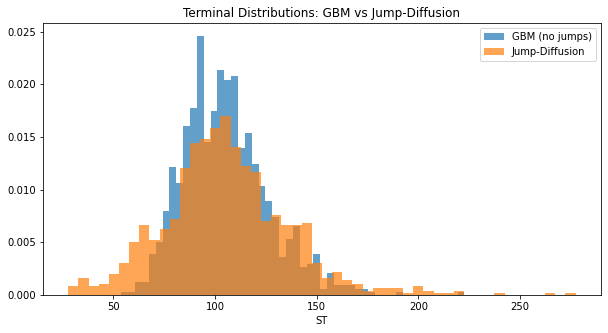

Jump-Diffusion replication residual norm: 290.4316 (higher than pure GBM due to jumps—unhedgeable risk).
Interpretation: Jumps create fat tails/outliers—stock/bond can't span, larger errors vs diffusion-only (real crashes harder to hedge).


In [3]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.stats import norm

# Exercise 1: Compute martingale measure Q numerically (non-negative, sum=1, prices assets)
# Real-world tie-in: In incomplete large-state markets, multiple Q exist—solve for one (e.g., variance-minimizing or entropy). Here, simple LP for feasibility; verifies no-arb pricing on traded assets (e.g., bond/stock in many paths).
np.random.seed(42)
num_paths = 1000  # Large discrete state space
S0 = 100
r = 0.05          # Risk-free rate
T = 1.0
M0 = np.array([1 / (1 + r), S0])  # Discounted bond + stock price

# Traded assets: Discounted bond (pays 1 everywhere), discounted stock payoffs
B_disc = np.ones(num_paths) / (1 + r)  # Already discounted
ST = S0 * np.exp((r - 0.5 * 0.2**2) * T + 0.2 * np.sqrt(T) * np.random.standard_normal(num_paths))  # Risk-neutral paths for simplicity
S_disc = ST / (1 + r)

M = np.column_stack((B_disc, S_disc))  # Payoff matrix (discounted)

# Find Q: min c·q s.t. M^T q = M0, q >=0, sum q=1 (here c=0 for feasibility)
c = np.zeros(num_paths)  # Arbitrary objective
A_eq = np.vstack((np.ones(num_paths), M.T))  # sum q=1, M^T q = M0
b_eq = np.array([1, *M0])

bounds = [(0, None) for _ in range(num_paths)]

res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

Q = res.x if res.success else None

print("Martingale Q found:" if res.success else "No Q found (arb opportunity?)")
if Q is not None:
    print(f"  Sum Q: {Q.sum():.4f}")
    print(f"  Prices reproduced: Bond {np.dot(Q, B_disc):.4f}, Stock {np.dot(Q, S_disc):.4f}")
    print("Verification: Q prices traded assets correctly (no-arb); non-negative for positivity.")

# Exercise 2: Monte Carlo European option pricing under GBM + Black-Scholes benchmark
# Real-world: Standard MC for path-dependent/exotics; benchmark BS for validation (e.g., TSLA vanilla options).
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

K = 100
sigma = 0.2
num_mc = 100000

# MC under risk-neutral GBM
Z_mc = np.random.standard_normal(num_mc)
ST_mc = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_mc)
call_mc = np.maximum(ST_mc - K, 0)
C0_mc = np.exp(-r * T) * np.mean(call_mc)
std_err = np.exp(-r * T) * np.std(call_mc) / np.sqrt(num_mc)

bs_price = black_scholes_call(S0, K, T, r, sigma)

print(f"\nMC Call Price: {C0_mc:.4f} ± {std_err:.4f} (SE)")
print(f"Black-Scholes benchmark: {bs_price:.4f}")
print(f"Difference: {abs(C0_mc - bs_price):.4f} (within error for large MC)")

# Exercise 3: Jump diffusion—compare distributions and replication errors
# Real-world: Jumps model crashes/earnings (e.g., TSLA news jumps). Increases tail risk, harder replication (incomplete).
lambda_jump = 0.5     # Jump intensity
mu_jump = -0.1        # Mean jump size
sigma_jump = 0.3      # Jump vol

# Merton jump-diffusion paths
num_jumps = np.random.poisson(lambda_jump * T, num_paths)
jump_factors = np.exp(mu_jump * num_jumps + sigma_jump * np.sqrt(num_jumps) * np.random.standard_normal(num_paths))
ST_jump = S0 * np.exp((r - 0.5 * sigma**2 - lambda_jump * (np.exp(mu_jump + 0.5*sigma_jump**2) - 1)) * T +
                      sigma * np.sqrt(T) * np.random.standard_normal(num_paths)) * jump_factors

# Distributions comparison
plt.figure(figsize=(10, 5))
plt.hist(ST, bins=50, alpha=0.7, label='GBM (no jumps)', density=True)
plt.hist(ST_jump, bins=50, alpha=0.7, label='Jump-Diffusion', density=True)
plt.title('Terminal Distributions: GBM vs Jump-Diffusion')
plt.xlabel('ST')
plt.legend()
plt.show()

# Replication error: Least-squares hedge with bond + stock on jump paths (incomplete)
M_jump = np.column_stack((np.ones(num_paths)/(1+r), ST_jump/(1+r)))  # Discounted
C1_jump = np.maximum(ST_jump - K, 0)  # Call payoff on jump paths

phi_ls_jump, _, _, _ = np.linalg.lstsq(M_jump, C1_jump/(1+r), rcond=None)  # Discounted claim
replicated_jump = M_jump @ phi_ls_jump
residual_jump = (C1_jump / (1+r)) - replicated_jump
norm_jump = np.linalg.norm(residual_jump)

print(f"Jump-Diffusion replication residual norm: {norm_jump:.4f} (higher than pure GBM due to jumps—unhedgeable risk).")
print("Interpretation: Jumps create fat tails/outliers—stock/bond can't span, larger errors vs diffusion-only (real crashes harder to hedge).")

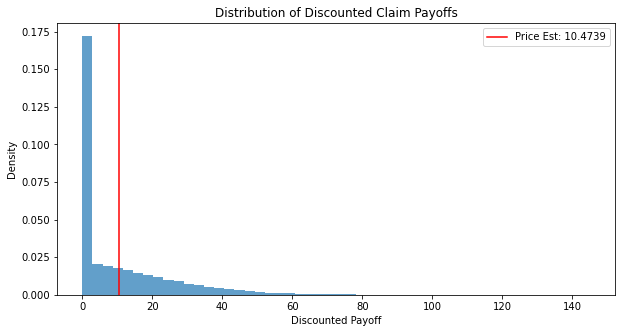

Price Estimate: 10.4739
95% CI: [10.3826, 10.5652]
Least-squares hedge ϕ: Bond -56.92, Stock shares 0.6738
Residual norm: 1773.9807


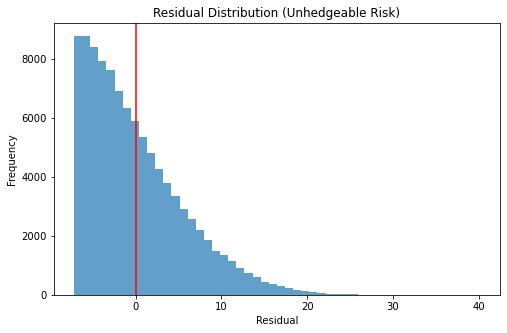


Fun Twist: Stress Scenarios Comparison
Least-squares hedge ϕ: Bond -56.92, Stock shares 0.6738
Residual norm: 1773.9807


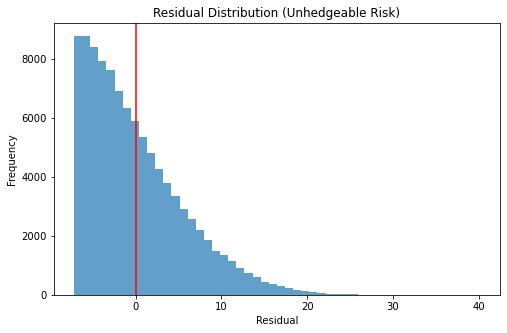

Price Estimate: 18.0687
95% CI: [17.8747, 18.2626]
Least-squares hedge ϕ: Bond -52.04, Stock shares 0.7007
Residual norm: 3560.1211


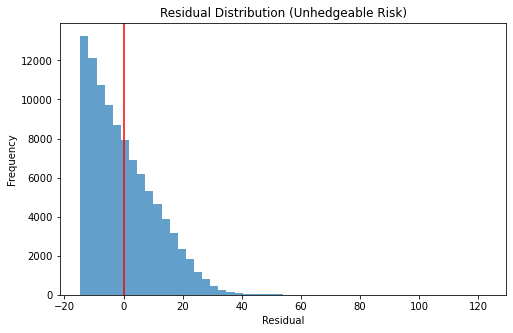

Least-squares hedge ϕ: Bond -49.36, Stock shares 0.6276
Residual norm: 2866.5438


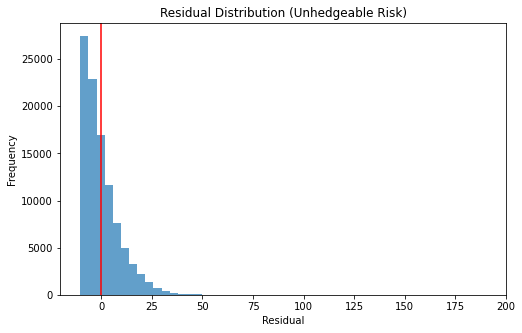

Base residual norm: 1773.9807
High vol stress norm: 3560.1211 (+100.7%)
Jump stress norm: 2866.5438 (+61.6%)
Interpretation: Stress (higher vol/jumps) increases hedging errors—unhedgeable tail/crash risk grows, as bond/stock can't capture extremes.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Reusable Monte Carlo pricer sandbox
# Real-world tie-in: Large static MC for pricing/hedging under GBM (e.g., TSLA options). Confidence intervals quantify estimation error; hedging regression approximates delta in incomplete/large markets.
class StaticPricer:
    def __init__(self, S0=100, r=0.05, T=1.0, sigma=0.2, num_paths=100000, seed=42):
        self.S0 = S0
        self.r = r
        self.T = T
        self.sigma = sigma
        self.num_paths = num_paths
        np.random.seed(seed)
    
    def simulate_gbm(self):
        Z = np.random.standard_normal(self.num_paths)
        ST = self.S0 * np.exp((self.r - 0.5 * self.sigma**2) * self.T + self.sigma * np.sqrt(self.T) * Z)
        return ST
    
    def price_claim(self, claim_payoff_func, K=100, plot_diagnostics=True):
        ST = self.simulate_gbm()
        payoff = claim_payoff_func(ST, K)
        disc_payoff = np.exp(-self.r * self.T) * payoff
        
        price_est = np.mean(disc_payoff)
        std_err = np.std(disc_payoff) / np.sqrt(self.num_paths)
        ci_lower = price_est - 1.96 * std_err
        ci_upper = price_est + 1.96 * std_err
        
        if plot_diagnostics:
            plt.figure(figsize=(10, 5))
            plt.hist(disc_payoff, bins=50, alpha=0.7, density=True)
            plt.title('Distribution of Discounted Claim Payoffs')
            plt.xlabel('Discounted Payoff')
            plt.ylabel('Density')
            plt.axvline(price_est, color='red', label=f'Price Est: {price_est:.4f}')
            plt.legend()
            plt.show()
        
        print(f"Price Estimate: {price_est:.4f}")
        print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        
        return price_est, (ci_lower, ci_upper), disc_payoff, ST
    
    def approximate_hedge(self, disc_payoff, ST):
        # Traded: Discounted bond (1) and discounted stock
        disc_bond = np.ones(self.num_paths)
        disc_stock = ST * np.exp(-self.r * self.T)
        M = np.column_stack((disc_bond, disc_stock))
        
        # Least-squares hedge
        phi_hat, _, _, _ = np.linalg.lstsq(M, disc_payoff, rcond=None)
        replicated = M @ phi_hat
        residual = disc_payoff - replicated
        residual_norm = np.linalg.norm(residual)
        
        print(f"Least-squares hedge ϕ: Bond {phi_hat[0]:.2f}, Stock shares {phi_hat[1]:.4f}")
        print(f"Residual norm: {residual_norm:.4f}")
        
        # Residual distribution
        plt.figure(figsize=(8, 5))
        plt.hist(residual, bins=50, alpha=0.7)
        plt.title('Residual Distribution (Unhedgeable Risk)')
        plt.xlabel('Residual')
        plt.ylabel('Frequency')
        plt.axvline(0, color='red')
        plt.show()
        
        return phi_hat, residual

# Example: European call
pricer = StaticPricer()

def call_payoff(ST, K):
    return np.maximum(ST - K, 0)

price, ci, disc_payoff, ST = pricer.price_claim(call_payoff, K=100)

# Hedging module
pricer.approximate_hedge(disc_payoff, ST)

# Fun twist: Stress scenarios—higher vol and mild jumps, compare hedging errors
print("\nFun Twist: Stress Scenarios Comparison")

# Base (normal vol)
base_norm = pricer.approximate_hedge(disc_payoff, ST)[1]
base_norm_norm = np.linalg.norm(base_norm)

# High volatility stress
stress_pricer = StaticPricer(sigma=0.4)  # Double vol
_, _, stress_disc, stress_ST = stress_pricer.price_claim(call_payoff, K=100, plot_diagnostics=False)
stress_norm = stress_pricer.approximate_hedge(stress_disc, stress_ST)[1]
stress_norm_norm = np.linalg.norm(stress_norm)

# Mild jump stress (add Poisson jumps)
jump_lambda = 0.5
jump_mu = -0.1
jump_sigma = 0.3
num_jumps = np.random.poisson(jump_lambda * pricer.T, pricer.num_paths)
jump_factor = np.exp(jump_mu * num_jumps + jump_sigma * np.sqrt(num_jumps) * np.random.standard_normal(pricer.num_paths))
ST_jump = ST * jump_factor  # Overlay on base GBM paths
disc_payoff_jump = np.exp(-pricer.r * pricer.T) * np.maximum(ST_jump - 100, 0)
jump_norm = pricer.approximate_hedge(disc_payoff_jump, ST_jump)[1]
jump_norm_norm = np.linalg.norm(jump_norm)

print(f"Base residual norm: {base_norm_norm:.4f}")
print(f"High vol stress norm: {stress_norm_norm:.4f} (+{(stress_norm_norm / base_norm_norm - 1):.1%})")
print(f"Jump stress norm: {jump_norm_norm:.4f} (+{(jump_norm_norm / base_norm_norm - 1):.1%})")
print("Interpretation: Stress (higher vol/jumps) increases hedging errors—unhedgeable tail/crash risk grows, as bond/stock can't capture extremes.")